In [50]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from Bio.SeqIO.FastaIO import SimpleFastaParser
import os
from upsetplot import UpSet

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

#run_type = "dry"
run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"Control":"#000000", "Rapa Adult":"#5a9f68", 
           "Rapa Early":"#4170b0", "Rapa Late":"#c34e0d"}

path = "../analysis/plots/expression/"

In [51]:
df = pd.read_csv("../analysis/CLEAN_ASVs_counts_merged.tsv", sep = "\t")
df.columns = ["Sample_ID"] + list(df.columns[1:])
metadata = pd.read_csv("../metadata_rapaInter.csv")

In [52]:
# Sort metadata according to columnames to help understand groups
sorter = list(df.columns[1:])
metadata.Sample_ID = metadata.Sample_ID.astype("category")
metadata.Sample_ID = metadata.Sample_ID.cat.set_categories(sorter)
metadata = metadata.sort_values(["Sample_ID"])
metadata.set_index("Sample_ID", inplace = True)

df.set_index("Sample_ID", inplace = True)

# Transpose df and merge with metadata
expr = pd.merge(df.T, metadata, left_index = True, right_index = True)

In [54]:
# Read fasta with ASV names to put OTU into our dataframe
with open('../analysis/CLEAN_ASVs_merged.fa') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for title, sequence in SimpleFastaParser(fasta_file):
        identifiers.append(title.split(None, 1)[0])  # First word is ID
        seqs.append(sequence)

fasta_tuples = list(zip(identifiers, seqs))
df_fa = pd.DataFrame(fasta_tuples, columns = ["OTU", "sequence"])

# Define the directory containing the files
data_dir = "../analysis/deseq_timepoints_new/"

# List all files in the directory
all_files = os.listdir(data_dir)
csv_files = [f for f in all_files if f.endswith(".csv")]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each file
for filename in csv_files:
    # Extract key (filename before second underscore)
    key = '_'.join(filename.split("_")[0:3])
  
    # Read the file and store in the dictionary
    data_dict[key] = pd.read_csv(os.path.join(data_dir, filename), sep=";")

# Concatenate the dataframes using the dictionary
mat = pd.concat(data_dict.values(), keys=data_dict.keys())

mat.reset_index(inplace = True)
mat.columns = ["fullname", "trash", "sequence", 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue',
       'padj', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
mat.drop(columns = ["trash"], inplace = True)
mat[["Comparison", "fullname"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat[["Age", "Sex"]] = mat["fullname"].str.split('_', n=1, expand=True)
mat.drop(columns = ["fullname"], inplace = True)
# Make a tax column to compare to lefse
mat["tax"] = mat[["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]].astype(str).agg("_".join, axis = 1)
mat["tax"] = list(mat["tax"].str.replace("_nan", "_NA"))

# Merge matrix with FC and stuff with the correspondence to otu name
mer = pd.merge(mat, df_fa, how = "left", on = "sequence")

In [88]:
# Get otus to show
ots = {}

for e in ['Candidatus_Arthromitus', 'Lachnospiraceae_UCG-001', 
                      'Ruminiclostridium_5', 'Lachnoclostridium',
                      'Lachnospiraceae_NK4A136_group']:
    ots[e] = list(mer[mer["Genus"] == e]["OTU"].unique())
    print(e)
    display(mer[mer["Genus"] == e].loc[:, ["log2FoldChange", "padj", "Comparison", "Age", "Sex", "OTU"]])

Candidatus_Arthromitus


,log2FoldChange,padj,Comparison,Age,Sex,OTU
1840,4.676004,0.026683,SexRapaEarly,Old,20240404.csv,ASV_694
1841,5.191363,0.038460,RapaLateRapaEarly,Old,M,ASV_694
1842,-4.466720,0.036402,RapaAdultRapaEarly,Mid,F,ASV_694


Lachnospiraceae_UCG-001


,log2FoldChange,padj,Comparison,Age,Sex,OTU
130,3.366254,2.723452e-07,RapaAdultRapaEarly,Mid,ALL,ASV_20
131,-2.931407,2.790862e-02,ControlRapaAdult,Mid,M,ASV_20
132,-1.983771,4.510583e-02,ControlRapaAdult,Young,ALL,ASV_20
133,-3.446112,2.456776e-02,ControlRapaAdult,Mid,F,ASV_20
134,-3.300876,1.821958e-04,ControlRapaAdult,Mid,ALL,ASV_20
135,-2.788963,3.872514e-02,RapaLateRapaEarly,Old,M,ASV_20
136,2.711569,8.133078e-03,RapaAdultRapaEarly,Mid,M,ASV_20
137,-3.450121,2.701396e-03,ControlRapaAdult,Young,M,ASV_20
138,3.744980,1.641424e-05,RapaAdultRapaEarly,Mid,F,ASV_20
249,3.050459,1.870466e-05,RapaAdultRapaEarly,Mid,ALL,ASV_55


Ruminiclostridium_5


,log2FoldChange,padj,Comparison,Age,Sex,OTU
660,2.533444,1.137231e-02,RapaAdultRapaEarly,Mid,ALL,ASV_375
661,6.808632,5.577241e-08,ControlRapaLate,Old,F,ASV_375
662,-3.834853,1.321732e-02,ControlRapaAdult,Mid,M,ASV_375
663,3.954017,3.266018e-02,ControlRapaAdult,Old,F,ASV_375
664,6.531163,2.165686e-02,SexControl,Old,20240404.csv,ASV_375
665,-2.828961,3.003178e-02,ControlRapaAdult,Mid,ALL,ASV_375
666,3.394217,1.250163e-02,RapaAdultRapaEarly,Mid,M,ASV_375
667,2.828532,1.729209e-02,RapaAdultRapaLate,Old,F,ASV_375
668,4.555625,1.853842e-02,SexControl,Mid,20240404.csv,ASV_375
669,-3.348990,3.566980e-02,SexRapaLate,Old,20240404.csv,ASV_375


Lachnoclostridium


,log2FoldChange,padj,Comparison,Age,Sex,OTU
406,1.484428,0.008831,RapaAdultRapaEarly,Mid,ALL,ASV_138
407,-3.518406,0.000229,SexRapaEarly,Old,20240404.csv,ASV_138
408,3.146531,0.001652,RapaLateRapaEarly,Old,F,ASV_138
409,-1.955844,0.017994,SexRapaAdult,Young,20240404.csv,ASV_138
410,-3.788231,0.000005,SexRapaAdult,Old,20240404.csv,ASV_138
...,...,...,...,...,...,...
1844,5.340684,0.025844,RapaLateRapaEarly,Old,M,ASV_876
1845,4.819957,0.046461,SexRapaEarly,Old,20240404.csv,ASV_922
1846,4.881284,0.045546,SexRapaEarly,Old,20240404.csv,ASV_926
2132,-1.324005,0.019701,SexRapaEarly,Mid,20240404.csv,ASV_87


Lachnospiraceae_NK4A136_group


,log2FoldChange,padj,Comparison,Age,Sex,OTU
5,-10.759683,2.384571e-03,ControlRapaEarly,Mid,F,ASV_46
6,-11.062302,6.101793e-06,ControlRapaLate,Old,F,ASV_46
7,-7.018034,6.279667e-06,ControlRapaAdult,Mid,M,ASV_46
8,-6.741357,5.751623e-03,ControlRapaAdult,Old,F,ASV_46
9,-10.769349,7.146666e-10,ControlRapaLate,Old,ALL,ASV_46
...,...,...,...,...,...,...
2128,-9.447936,4.749815e-11,SexRapaLate,Old,20240404.csv,ASV_78
2129,-6.323763,2.319006e-03,RapaAdultRapaLate,Old,M,ASV_78
2130,-6.700775,9.374352e-04,RapaAdultRapaEarly,Mid,F,ASV_78
2135,-1.445897,2.489722e-02,SexRapaEarly,Mid,20240404.csv,ASV_142


In [68]:
expr

,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,ASV_4092,ASV_4093,ASV_4094,ASV_4095,ASV_4096,Mouse_ID,Sex,Treatment_SG,Treatment,Age
Plate1_A1,16520,9898,474,3754,3977,1587,1017,1484,2009,0,...,0,0,0,0,0,TNES-BK48,f,Rapamycin conti (RC),Rapa Adult,Old
Plate1_A10,14438,8690,2557,4349,4937,2110,3365,4770,1802,1111,...,0,0,0,0,0,TNES-BH32,f,Rapamycin conti (RC),Rapa Adult,Young
Plate1_A11,55,26,45,63,76,378,4,177,2035,19529,...,0,0,0,0,0,TNES-BM39,f,Control,Control,Old
Plate1_A12,16,7,1932,334,309,682,417,930,100,12127,...,0,0,0,0,0,TNES-BS28,m,Rapa memory Early (RM E),Rapa Early,Mid
Plate1_A2,7,0,989,1950,2075,1242,1709,98,78,14536,...,0,0,0,0,0,TNES-BJ14,f,Rapamycin conti (RC),Rapa Adult,Mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Plate4_F1,8150,4718,191,5,5,8,1339,2234,4270,26,...,0,0,0,0,0,TNES-BH57,f,Rapa memory Late (RM L),Rapa Late,Old
Plate4_F2,42340,26130,15,0,8,518,1107,3366,2453,0,...,0,0,0,0,0,TNES-BI53,f,Rapa memory Late (RM L),Rapa Late,Old
Plate4_F3,9001,5138,1635,4714,4775,2148,3234,244,517,2,...,5,5,5,5,5,TNES-BR49,m,Rapamycin conti (RC),Rapa Adult,Mid
Plate4_G1,14284,8906,3890,54,81,2534,1963,2245,5377,4,...,0,0,0,0,0,TNES-BS14,m,Control,Control,Old


In [73]:
ots["Candidatus_Arthromitus"][0]

'ASV_694'

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: Runtime

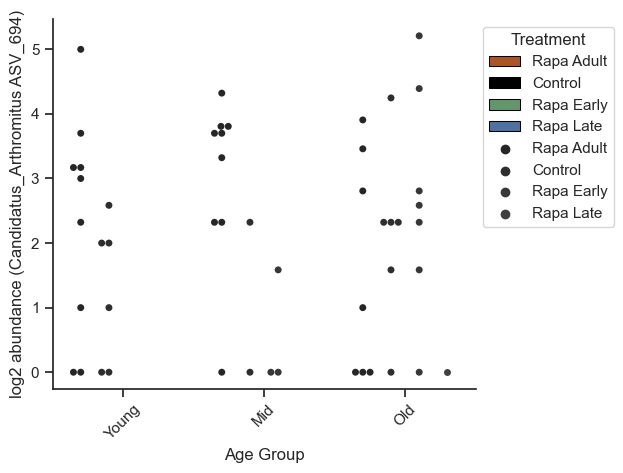

In [86]:
palettesex = {'Control': '#000000',
 'Rapa Adult': '#c34e0d',
 'Rapa Early': '#5a9f68',
 'Rapa Late': '#4170b0'}

df = expr.loc[:, ots["Candidatus_Arthromitus"] + ["Sex", "Treatment", "Age"]]

df[ots["Candidatus_Arthromitus"][0]] = np.log2(df[ots["Candidatus_Arthromitus"][0]])

ax = sns.boxplot(df, x="Age", y = ots["Candidatus_Arthromitus"][0], hue = "Treatment", palette = palettesex, 
           order = ["Young", "Mid", "Old"], showfliers = False)

ax = sns.swarmplot(df, x="Age", y = ots["Candidatus_Arthromitus"][0], hue = "Treatment",
                      dodge = True, color = ".25", ax = ax, order = ["Young", "Mid", "Old"])

plt.xlabel("Age Group")
plt.ylabel(f"log2 abundance ({'Candidatus_Arthromitus'} {ots['Candidatus_Arthromitus'][0]})")
plt.xticks(rotation=45)  # rotate x-axis labels for better readability
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()

/Users/CMonzo/software/miniconda/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


TypeError: loop of ufunc does not support argument 0 of type str which has no callable log2 method